
1.Скачиваем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>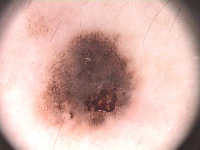</td><td>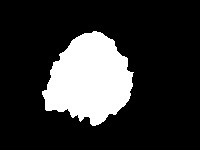</td></tr></table>

2. Разархивируем .rar файл.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...


Выполняем импорт необходимых библиотек:

In [ ]:
!pip install torchsummary
from skimage.io import imread
import os
import torch
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchsummary import summary
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
from torchvision import transforms
from PIL import Image

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


***Создаем списки из файлов изображений и файлов, содержащих Ground Truth. Работаем в Kaggle с предварительно загруженным датасетом по адресу ../input/ph2dataset/PH2Dataset***

In [ ]:
images = []
lesions = []


root = '../input/ph2dataset/PH2Dataset' #Здесь указать путь к папке с датасетом

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, выведем несколько изображений

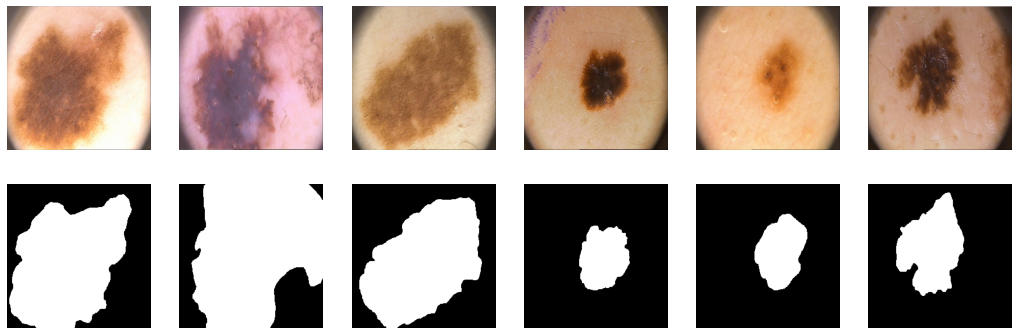

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap = "gray")
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
np.random.seed(1)
torch.manual_seed(1)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

#### PyTorch DataLoader

In [ ]:
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()

cuda


# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

# SegNet

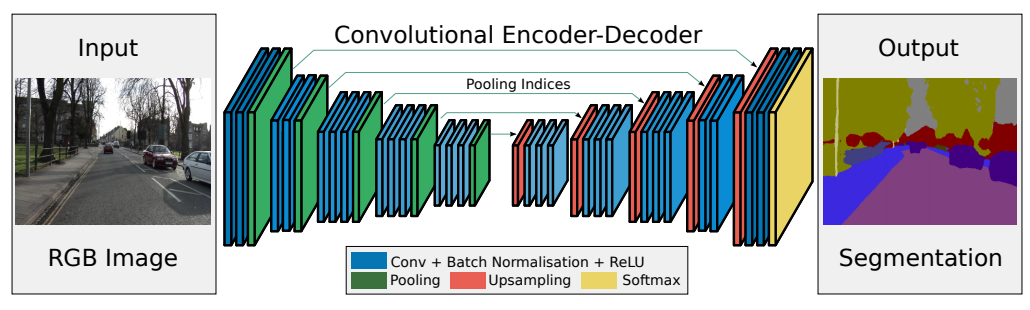

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

***В ходе экспериментов было выяснено, что при 64 фильтрах в первом сверточном слое (как в классическом SegNet) скор на нашей задаче не улучшается по сравнению с 32-мя фильтрами. Для экономии вычислительных ресурсов и более быстрых расчетов будем использовать 32 фильтра в первом сверточном слое.***

In [ ]:
num_ch = 32 #Число фильтров в первом сверточном слое

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size = 2, return_indices = True)# 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU()
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size = 2, return_indices = True)# 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= num_ch*2, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU()
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size = 2, return_indices = True)# 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),        
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size = 2, return_indices = True)# 32 -> 16
            
          
        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*16, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*16, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*16, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*16),
            nn.ReLU()
        )
        
        self.bottleneck_pool = nn.MaxPool2d(kernel_size = 2, return_indices = True)
        self.bottleneck_upsample = nn.MaxUnpool2d(2, stride=2)
        
        self.bottleneck_dec = nn.Sequential(          
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU()
        )
        
        
            
            
        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),          
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU()
        )       
        
        self.upsample1 =  nn.MaxUnpool2d(2, stride=2)# 32 -> 64
        
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU()
        )
        
        self.upsample2 =  nn.MaxUnpool2d(2, stride=2)# 64 -> 128
        
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU()
        )

        self.upsample3 =  nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=1, kernel_size=3, padding = (1,1)),
        )
        
        
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_enc(e3)
        b, ind_b = self.bottleneck_pool(b)
        b = self.bottleneck_upsample(b, ind_b)
        b = self.bottleneck_dec(b)

        # decoder
        d0 = self.upsample0(b, ind3)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0, ind2)
        d1 = self.dec_conv1(d1)        
        d2 = self.upsample2(d1, ind1)
        d2 = self.dec_conv2(d2)           
        d3 = self.upsample3(d2, ind0)
        d3 = self.dec_conv3(d3) # no activation  
        return d3

***Воспользуемся torchsummary, чтобы посмотреть структуру нашей сети:***

In [ ]:
print(summary(SegNet().to(DEVICE), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7  [[-1, 32, 128, 128], [-1, 32, 128, 128]]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14  [[

## Метрика

В данном разделе используем следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
        
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou  

## Функция потерь

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) Тарая функция эквивалентно первоначальной функции потерь и не так подвержено численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    #Сначала делаем усреднение по картинке (mean((1, 2, 3))), затем по батчу (mean())
    return (torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))).mean((1,2,3)).mean()

***Для проверки правильности реализации нашей функции bce_loss сравним результаты ее работы на случайном тензоре с результатами работы библиотечной функции nn.BCEWithLogitsLoss():***

In [ ]:
s1 = torch.randn(10, 3, 256, 256)
s2 = torch.randn(10, 3, 256, 256)
print(nn.BCEWithLogitsLoss()(s1, s2), bce_loss(s1, s2))

tensor(0.8068) tensor(0.8068)


***Результаты совпали, наша реализация верна.***

## Тренировка

Определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, use_sched = True, aug = False):
    """
    use_shed - будет ли использоваться экспоненциальный scheduler, aug - будут ли использоваться аугментации
    В словаре history будут храниться лоссы и скоры по эпохам
    """
    X_val, Y_val = next(iter(data_val))
    history = {"epochs": np.arange(epochs)+1, "train": {"score": [], "loss": []},  "val": {"score": [], "loss": []}}
    if use_sched:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer = opt, gamma=0.96)
   

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        transform_train = transforms.Compose([                #Аугментации
              transforms.RandomApply([
              transforms.ColorJitter(brightness=0.7,contrast=0.7,saturation=0.7),],
              p = 0.1),
              transforms.RandomApply([transforms.Grayscale(3),], p=0.1),                        
            ])
        avg_loss = 0
        avg_score = 0
        avg_loss_val = 0
        avg_score_val = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(DEVICE)
            if aug:
                X_batch = transform_train(X_batch)
            Y_batch = Y_batch.to(DEVICE)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()                 # backward-pass
            opt.step()                      # update weights
            score = iou_pytorch(torch.sigmoid(Y_pred) > 0.5, Y_batch).mean().item()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_score += score/ len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        if use_sched:
            scheduler.step()
        model.eval()  # testing mode
        Y_hat = model(X_val.to(DEVICE)).detach().to("cpu")  # detach and put into cpu
        loss_val = loss
        # Visualize tools
        clear_output(wait=True)         
       
        for Xv_batch, Yv_batch in data_val:
            Xv_batch = Xv_batch.to(DEVICE)
            Yv_batch = Yv_batch.to(DEVICE)
            Y_pred_val = model(Xv_batch)
            loss_val = loss_fn(Y_pred_val, Yv_batch)
            score_val = iou_pytorch(torch.sigmoid(Y_pred_val) > 0.5, Yv_batch).mean().item()
            avg_loss_val += loss / len(data_val)
            avg_score_val += score_val/ len(data_val)
            
        history["train"]["score"].append(avg_score)
        history["val"]["score"].append(avg_score_val)
        history["train"]["loss"].append(avg_loss.item())
        history["val"]["loss"].append(avg_loss_val.item())
        fig, ax = plt.subplots(3, 6, figsize = (14, 12))
        
        for k in range(6):
            ax[0, k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            ax[0, k].set_title("Real")
            ax[0, k].axis('off')
            ax[1, k].imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
            ax[1, k].set_title("Output")
            ax[1, k].axis('off') 
            ax[2, k].imshow(Y_val[k, 0], cmap='gray')
            ax[2, k].set_title("Ground Truth")
            ax[2, k].axis('off')                    
        plt.suptitle('%d / %d - train_loss: %f , val_loss: %f, train_score: %f, val_score: %f' % (epoch+1, epochs, avg_loss, avg_loss_val, avg_score, avg_score_val))
        plt.tight_layout()
        plt.show()
        
    return history

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
#Функция предсказания на новых данных, возвращающая тензор предсказанной маски и осуществляющая визуализацю сегментации
def predict(model, data): 
    model.eval()  # testing mode
    Y_pred = (torch.sigmoid(model(data.to(DEVICE)))>0.5).float().detach().to("cpu")
    nums = len(data)
    fig, ax = plt.subplots(2, nums, figsize = (14, 8))
    axc = ax.ravel()
    for i in range(nums):
        axc[i].imshow(np.rollaxis(data[i].numpy(), 0, 3))
        axc[i].axis("off")
        axc[i].set_title("real")
        axc[nums+i].imshow(Y_pred[i, 0], cmap = "gray")
        axc[nums+i].axis("off")
        axc[nums+i].set_title("segmented")
    plt.tight_layout()
    return np.array(Y_pred)

In [ ]:
#Функция для вычисления скора
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(DEVICE)))>0.5
        x = metric(Y_pred, Y_label.to(DEVICE))
        scores += metric(Y_pred, Y_label.to(DEVICE)).mean().item()
       
    return scores/len(data)

In [ ]:
#Функция для построения графиков лосса и скора по эпохам
def make_graph(history, model_name, loss_name):
    fig, ax = plt.subplots(1, 2, figsize = (14, 7))
    x = history["epochs"]
    loss_train = history["train"]["loss"]
    loss_val = history["val"]["loss"]
    score_train = history["train"]["score"]
    score_val = history["val"]["score"]
    ax[0].plot(x, loss_train, label = "train", color = "green")
    ax[0].plot(x, loss_val, label = "val", color = "orange")
    ax[0].legend(fontsize = 14)
    ax[0].grid(linestyle = "--")
    ax[0].tick_params(labelsize = 14)
    ax[0].set_xlabel("epoch", fontsize = 14)
    ax[0].set_ylabel("loss", fontsize = 14)
    ax[0].set_title("Loss vs epoch", fontsize = 16)
    ax[0].set_xlim(left = 0, right = x.max())
    ax[0].set_ylim(bottom = 0)
    ax[1].plot(x, score_train, label = "train", color = "green")
    ax[1].plot(x, score_val, label = "val", color = "orange")
    ax[1].legend(fontsize = 14)
    ax[1].grid(linestyle = "--")
    ax[1].tick_params(labelsize = 14)
    ax[1].set_xlabel("epoch", fontsize = 14)
    ax[1].set_ylabel("score", fontsize = 14)
    ax[1].set_title("Score vs epoch", fontsize = 16)
    ax[1].set_xlim(left = 0, right = x.max())
    ax[1].set_ylim(bottom = 0)
    plt.suptitle(f"Model = {model_name}, loss = {loss_name}", fontsize = 18, y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
#Функция для вычисления скора на валидации и тесте уже обученной модели
def scores(model):
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    print(f"\nScore на валидации: {val_score:.4f}, score на тесте: {test_score:.4f}")
    return val_score, test_score

## Обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


### 1.1 SegNet c bce loss

***Будем использовать оптимизатор AdamW с начальным lr = 3e-4 и weight_decay = 0.05 (помогает бороться с переобучением):***

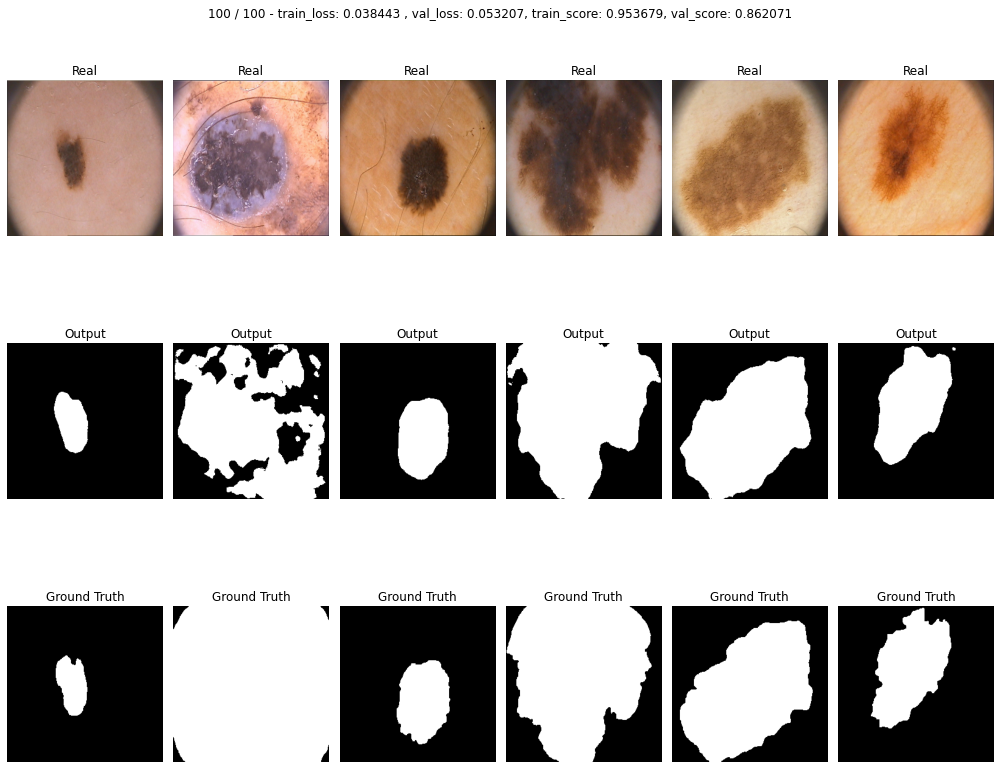

In [ ]:
torch.cuda.empty_cache()
model = SegNet().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_segnet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

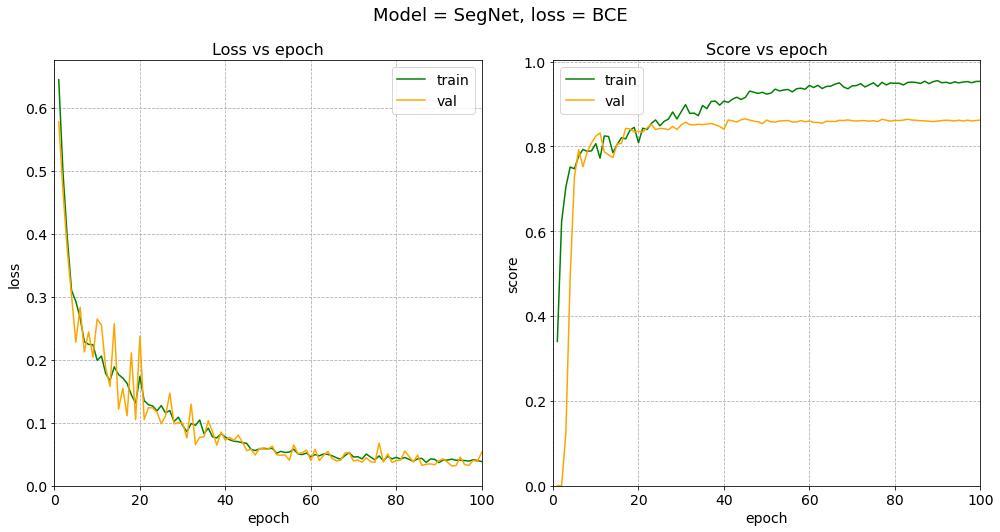

In [ ]:
make_graph(h_segnet_bce, "SegNet", "BCE")

In [ ]:
segnet_bce_val_score, segnet_bce_test_score = scores(model)


Score на валидации: 0.8621, score на тесте: 0.8371


### 1.2 SegNet c bce loss с аугментациями

***Посмотрим, приносит ли видимые улучшения использование аугментаций.***

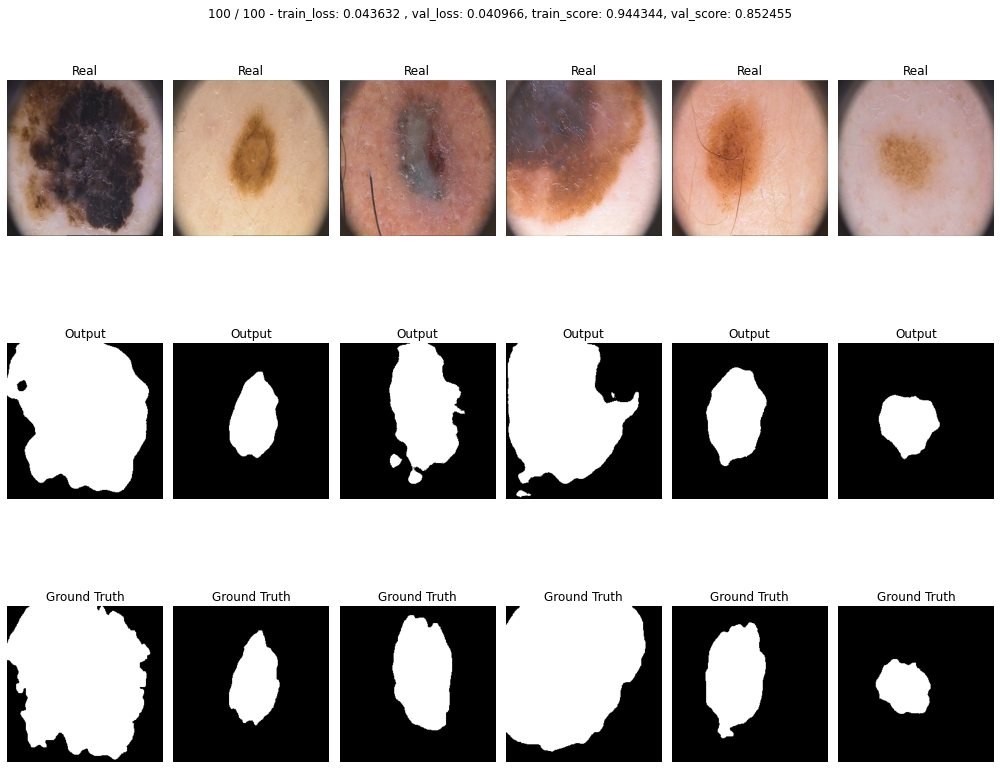

In [ ]:
torch.cuda.empty_cache()
model_aug = SegNet().to(DEVICE)
optimizer = torch.optim.AdamW(model_aug.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_segnet_bce_aug = train(model_aug, optimizer, bce_loss, max_epochs, data_tr, data_val, aug = True)

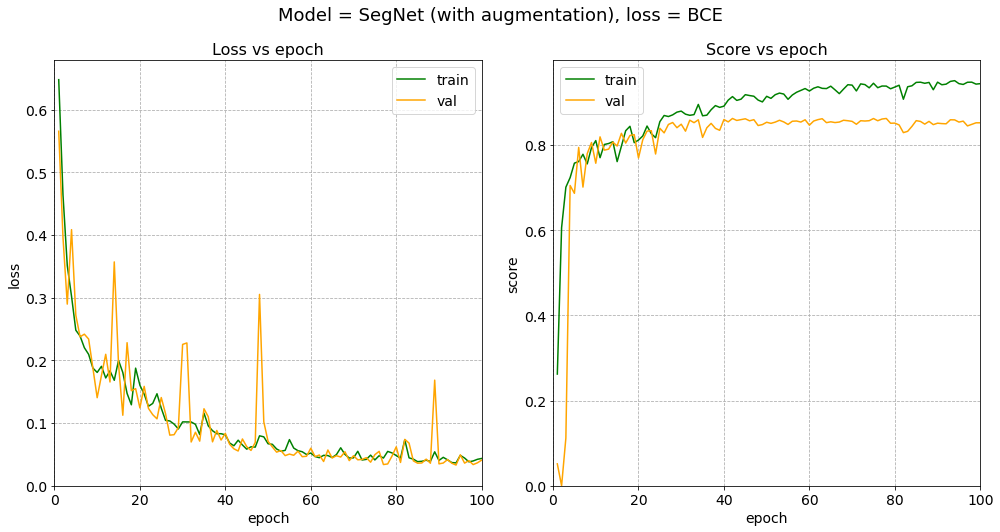

In [ ]:
make_graph(h_segnet_bce_aug, "SegNet (with augmentation)", "BCE")

In [ ]:
segnet_aug_bce_val_score, segnet_aug_bce_test_score = scores(model_aug)


Score на валидации: 0.8525, score на тесте: 0.8396


***Использование аугментаций не приводит к видимому улучшению скора или уменьшению разрыва между скорами на трейне и валиде для данной задачи, поэтому далее ее использовать нецелесообразно. У модели есть небольшое переобучение в том смысле, что скор на трейне превосходит скор на валиде и на тесте. Однако, нет такого явление, как наличие точки на графике, после прохождения которой метрика на трейне продолжает улучшаться, а метрика на валиде начинает ухудшаться (в этом смысле наша модель не переобучена)***

### 1.3 Демонстрация инференса

Посмотрим на предсказания модели на 8 картинках из тестового датасета:

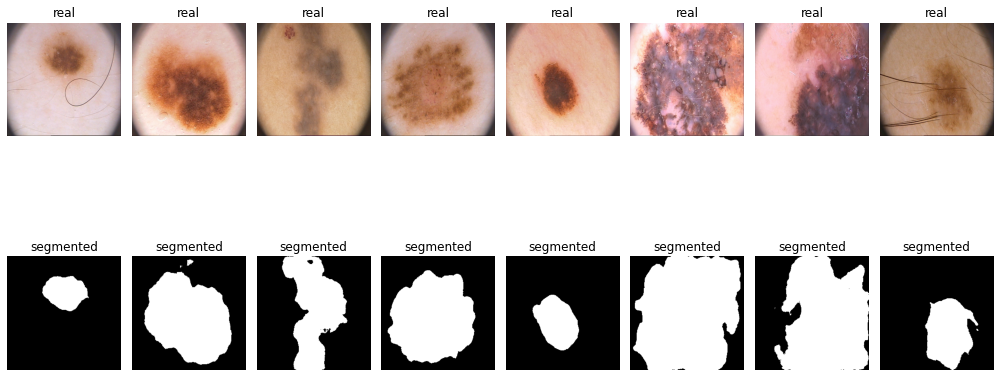

In [ ]:
xtest, _ = next(iter(data_ts))
xtest= xtest[:8]
pred1 = predict(model, xtest)

Посмотрим на предсказание модели на картинке, скачанной из интернета и не входящей ни в один из датасетов этой работы:

In [ ]:
! wget https://medcosmetologiya.com/images/slovar/nevus.jpg

--2020-12-18 11:32:07--  https://medcosmetologiya.com/images/slovar/nevus.jpg
Resolving medcosmetologiya.com (medcosmetologiya.com)... 37.46.133.97
Connecting to medcosmetologiya.com (medcosmetologiya.com)|37.46.133.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166554 (163K) [image/jpeg]
Saving to: ‘nevus.jpg.1’

nevus.jpg.1         100%[===================>] 162.65K   308KB/s    in 0.5s    

2020-12-18 11:32:09 (308 KB/s) - ‘nevus.jpg.1’ saved [166554/166554]



torch.Size([1, 3, 256, 256])

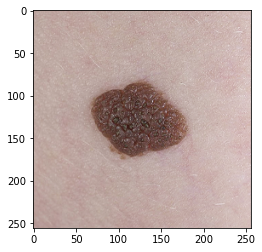

In [ ]:
im = Image.open("nevus.jpg")
im = resize(np.asarray(im), size, mode='constant', anti_aliasing=True)
plt.imshow(im);
im = transforms.ToTensor()(im).unsqueeze(0).type(torch.FloatTensor)
im.shape

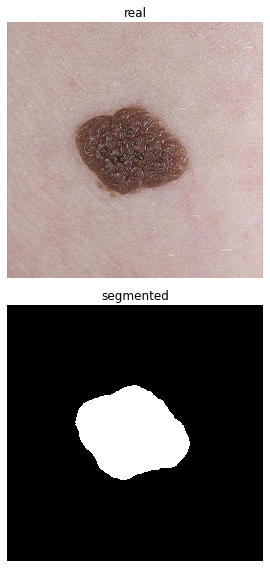

In [ ]:
pred2 = predict(model, im)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

**Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$


***В реализации Dice Loss мы используем параметр smooth. Он позволяет избежать ситуаций деления на 0 или выражений вида 0/0. Однако, в этом случае достаточно было бы взять smooth = 1e-5 или какому-нибудь другому маленькому числу, но мы берем smooth = 1 (наиболее популярная реализация dice_loss). Это делается для более плавного изменения функции dice_loss (без резких скачков между 0 и 1), поскольку она участвует в back_propagation. По этой же причине мы передаем в функцию сигмоиду от y_pred, а не y_pred, приведенный к виду только 0 или 1 (в этом случае dice_loss становится недиффернцируемым и сеть вообще перестает обучаться).***

In [ ]:
def dice_loss(y_pred, y_real):
    smooth = 1
    y_pred = torch.sigmoid(y_pred)
    num = (2*(y_pred*y_real) + smooth).sum((1,2,3)) #Суммирование в пределах картинки
    den = (y_pred+y_real+smooth).sum((1,2,3))       #Суммирование в пределах картинки
    res = 1 - (num/den).mean()                      #Усреднение по батчу
    return res 

### 1.4 Segnet с Dice loss

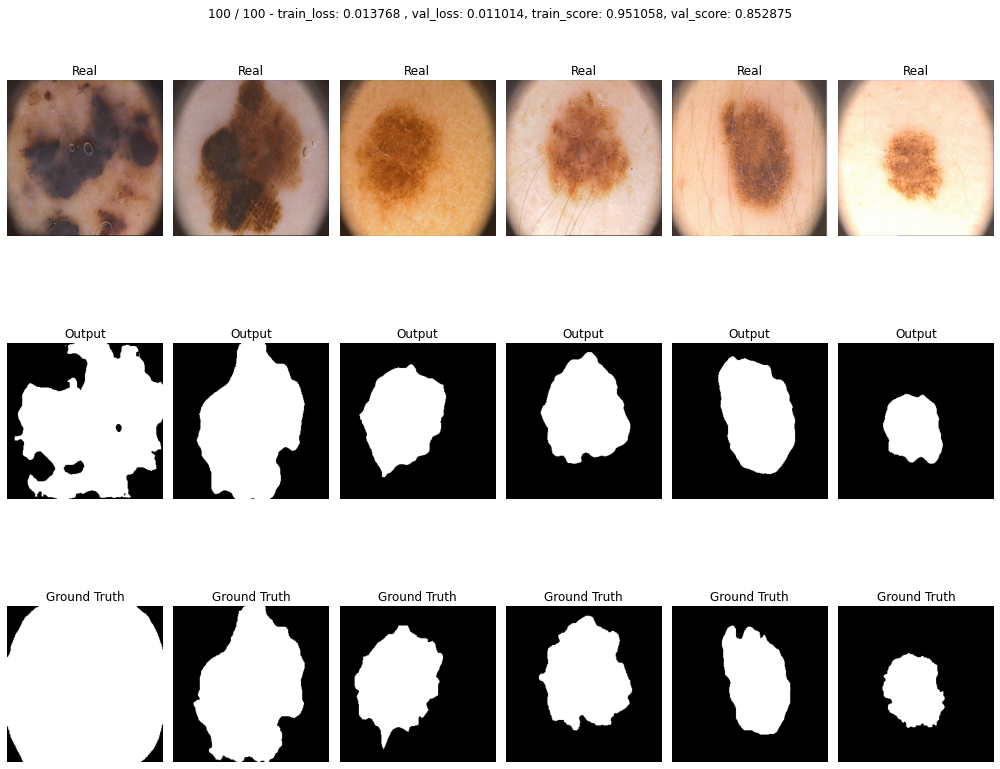

In [ ]:
torch.cuda.empty_cache()
model_dice = SegNet().to(DEVICE)
max_epochs = 100
optimizer = optim.AdamW(model_dice.parameters(), lr = 3e-4, weight_decay = 0.05)
h_segnet_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

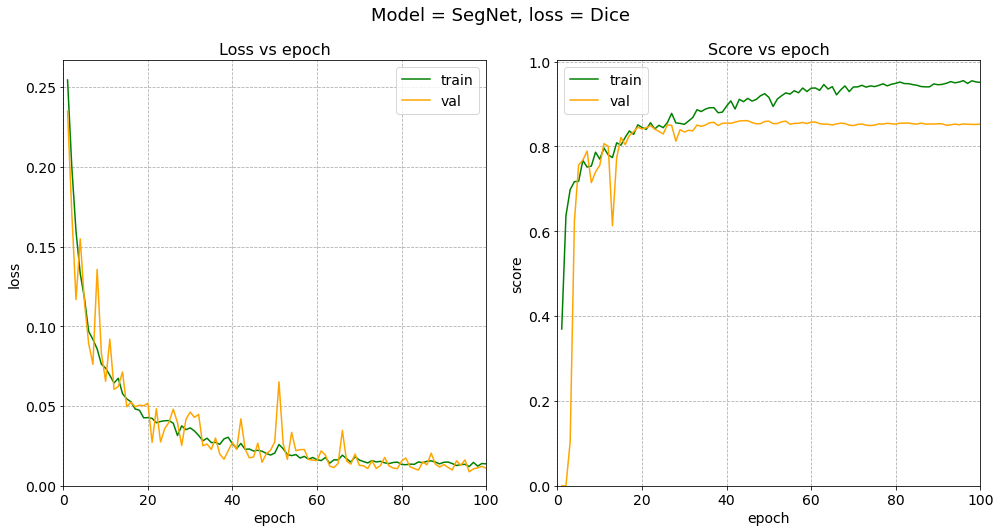

In [ ]:
make_graph(h_segnet_dice, "SegNet", "Dice")

In [ ]:
segnet_dice_val_score, segnet_dice_test_score = scores(model_dice)


Score на валидации: 0.8529, score на тесте: 0.8327


### 1.5 Segnet с Focal loss

In [ ]:
def focal_loss(y_pred, y_real, gamma = 2):
    #Используем вышенаписанную реализацию BCE (она устойчива, поэтому нам не требуется eps) за исключением усреднения
    #(будет сделано в конце функции focal_loss)
    BCE = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    pt = torch.exp(-BCE)
    L_foc = torch.pow(1-pt, gamma)*BCE
    your_loss = L_foc.mean((1,2,3)).mean()
    return your_loss

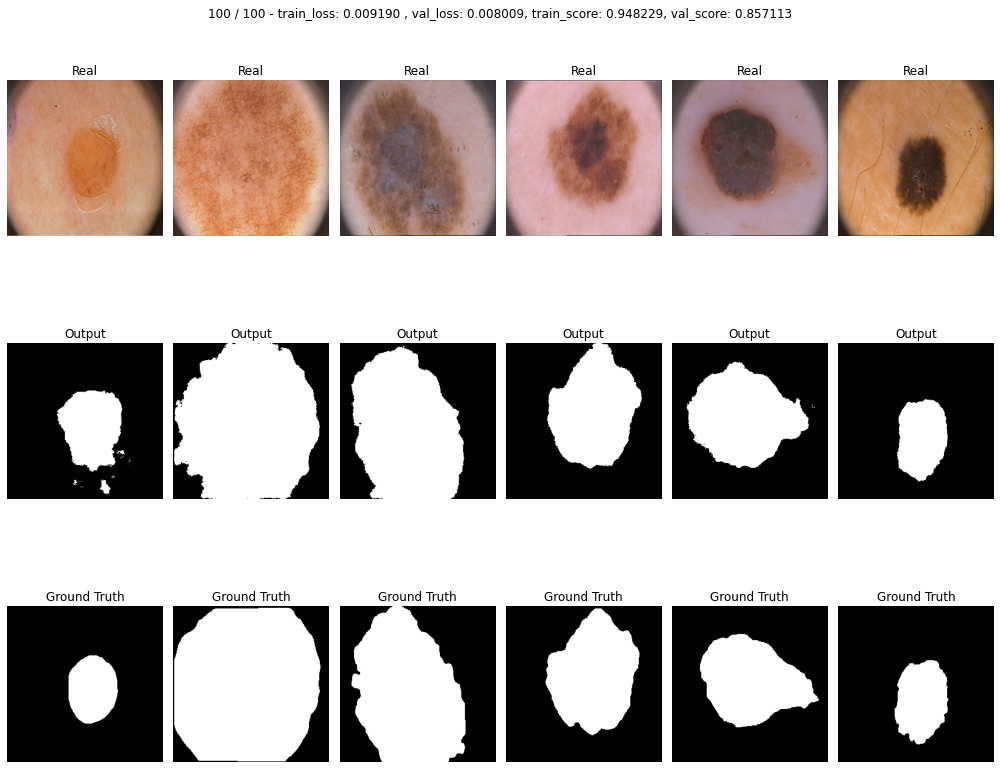

In [ ]:
torch.cuda.empty_cache()
model_focal = SegNet().to(DEVICE)
max_epochs = 100
optimizer = optim.AdamW(model_focal.parameters(), lr = 3e-4, weight_decay = 0.05)
h_segnet_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

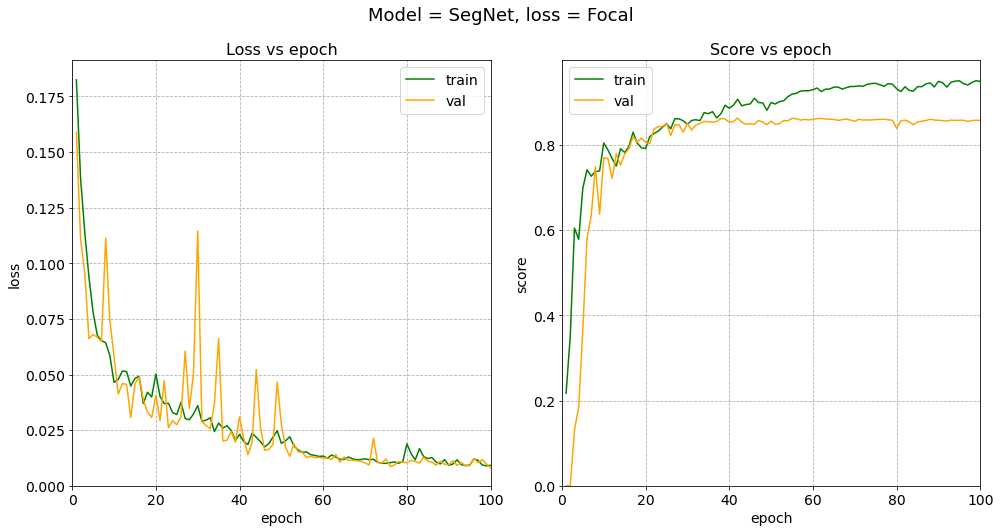

In [ ]:
make_graph(h_segnet_focal, "SegNet", "Focal")

In [ ]:
segnet_focal_val_score, segnet_focal_test_score = scores(model_focal)


Score на валидации: 0.8571, score на тесте: 0.8389


***Реализуем Correlation Maximized Structural Similarity Loss. Индекс SSIM определяется следующим образом:*** <br>
$\Large{SSIM(x,\ y)\ =\ \frac{(2{{\mu }_{x}}{{\mu }_{y}}+{{C}_{1}})(2{{\sigma }_{xy}}+{{C}_{2}})}{(\mu _{x}^{2}+\mu _{y}^{2}+{{C}_{1}})(\sigma _{x}^{2}+\sigma _{y}^{2}+{{C}_{2}})}}$ <br><br>
***Здесь x и y - тензоры сравниваемых картинок, $\mu_x, \mu_y$ - математические ожидания соотв. тензоров, $\sigma_x, \sigma_y$ - СКО соотв. тензоров, $\sigma_{xy}$ - ковариация между соотв. тензорами. Для оценки качества изображения полезно применять индекс SSIM локально, а не глобально. Во-первых, статистические характеристики изображений обычно сильно нестационарны в пространстве. Во-вторых, искажения изображения, которые могут зависеть или не зависеть от локальной статистики изображения, также могут быть пространственными. В-третьих, на типичных расстояниях просмотра только локальная область изображения может быть воспринята с высоким разрешением человеком-наблюдателем в один момент времени. Для определения локальных статистик будем использовать гауссово окно 11х11 с СКО = 1.5 (в соотв. со статьей), которое будет проходить по картинкам со stride = 1. Локальные статистики в пределах окна вычисляются по следующим формулам (где $w_i$ - весовые коэффициенты гауссового окна): <br>***
$\Large{{{\mu }_{x}}=\sum\limits_{i=1}^{N}{{{\omega }_{i}}{{x}_{i}}};\ \ \sigma _{x}^{2}=\sum\limits_{i=1}^{N}{{{\omega }_{i}}{{({{x}_{i}}-{{\mu }_{x}})}^{2}}};\ \ {{\sigma }_{xy}}=\sum\limits_{i=1}^{N}{{{\omega }_{i}}({{x}_{i}}-{{\mu }_{x}})({{y}_{i}}-{{\mu }_{y}}).}}$ <br>
***То есть вычисление локальных статистик по картинке сводится к операциям свертки, для чего будем использовать conv2d. SSIM по всей картинке вычисляется через локальные SSIM в гауссовых окнах следующим образом:<br>***
$\Large{SSIM(X,\ Y)=\frac{1}{M}\sum\limits_{j=1}^{M}{SSIM({{x}_{j}},\ {{y}_{j}}).}}$<br>
***SSL лосс вычисляется как 1 - SSIM.***

In [ ]:
def ssl_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred)
    window_size, sigma = 11, 1.5 #Размер окна и СКО 
    pad = window_size//2
    gauss =  torch.Tensor([np.exp(-(x - pad)**2/float(2*sigma**2)) for x in range(window_size)])
    gauss = (gauss/gauss.sum()).unsqueeze(1)
    window = (gauss @ gauss.t()).unsqueeze(0).unsqueeze(0).to(DEVICE) #Гауссово окно

    mu1 = F.conv2d(y_pred, window, padding=pad) #Тензор матожиданий y_pred в гауссовых окнах
    mu2 = F.conv2d(y_real, window, padding=pad) #Тензор матожиданий y_real в гауссовых окнах
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2
    #Используем следующие факты: D(x) = E(x**2)- (E(x))**2; Cov(x, y) = E(xy) - E(x)E(y), где D - дисперсия, E - матожидание. 
    sigma1_sq = F.conv2d(y_pred * y_pred, window, padding=pad) - mu1_sq #Тензор дисперсии y_pred в гауссовых окнах
    sigma2_sq = F.conv2d(y_real * y_real, window, padding=pad) - mu2_sq #Тензор дисперсии y_real в гауссовых окнах
    sigma12 =   F.conv2d(y_pred * y_real, window, padding=pad) - mu12   #Тензор ковариации y_pred с y_real в гауссовых окнах
    
    C1 = (0.01 ) ** 2  
    C2 = (0.03 ) ** 2
    
    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    return  (1 - (numerator1 * numerator2) / (denominator1 * denominator2)).mean()

### 1.6 Segnet с Structural Similarity Loss

***Сходимость с SSL лоссом более медленная, чем с передыдущими лоссами, поэтому начальный lr установим в 1e-3, чтобы на первых шагах модель обучалась быстрее. Кроме того, модель с SSL менее склонна к переобучению, поэтому уменьшим weight_decay до 0.01***

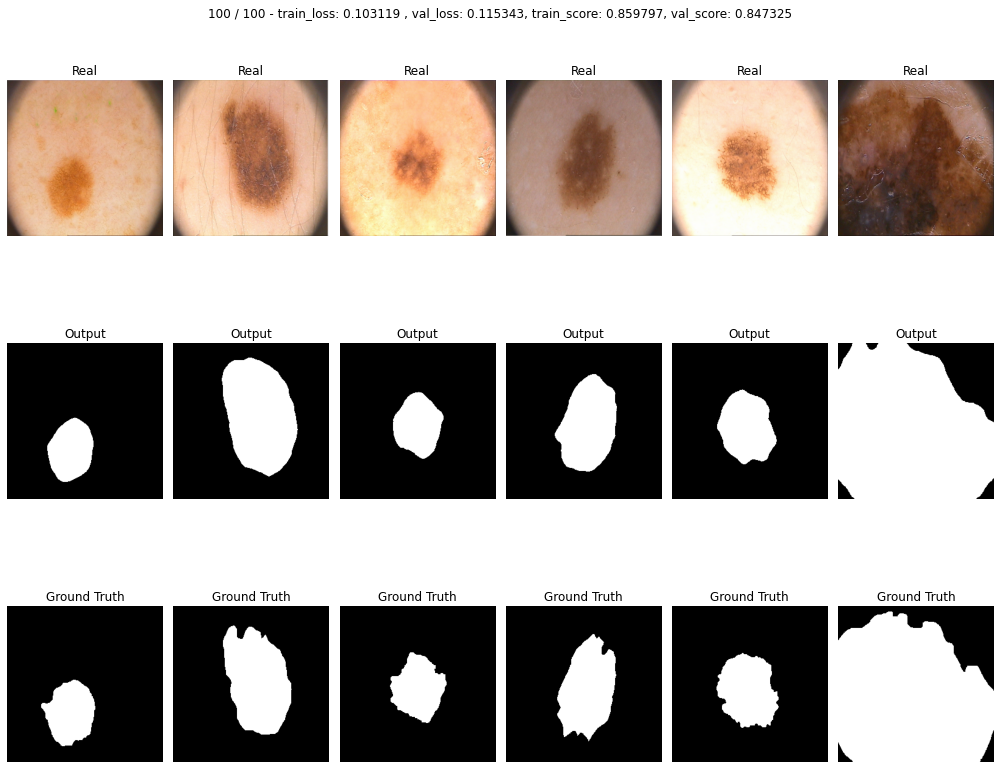

In [ ]:
torch.cuda.empty_cache()
model_ssl = SegNet().to(DEVICE)
max_epochs = 100
optimizer = optim.AdamW(model_ssl.parameters(), lr = 1e-3, weight_decay = 0.01)
h_segnet_ssl = train(model_ssl, optimizer, ssl_loss, max_epochs, data_tr, data_val)

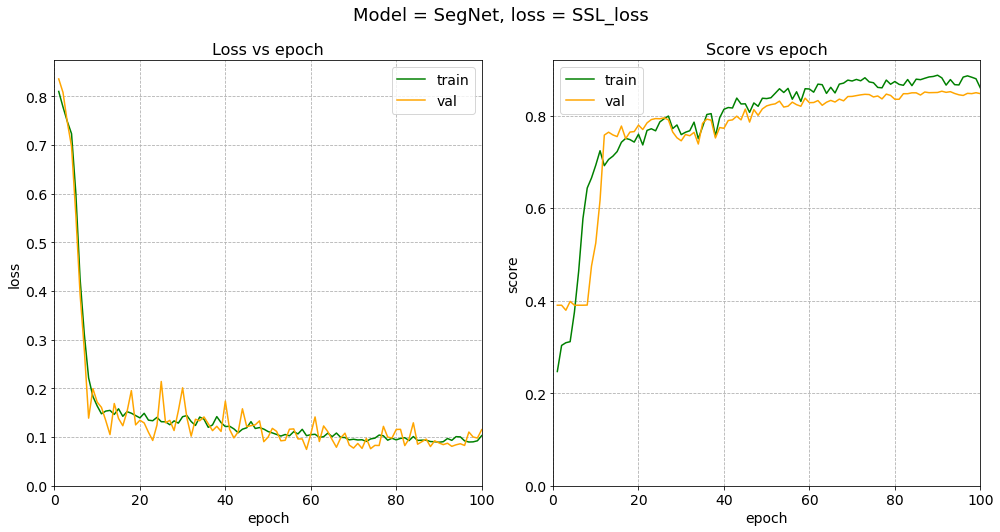

In [ ]:
make_graph(h_segnet_ssl, "SegNet", "SSL_loss")

In [ ]:
segnet_ssl_val_score, segnet_ssl_test_score = scores(model_ssl)


Score на валидации: 0.8473, score на тесте: 0.8279


-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

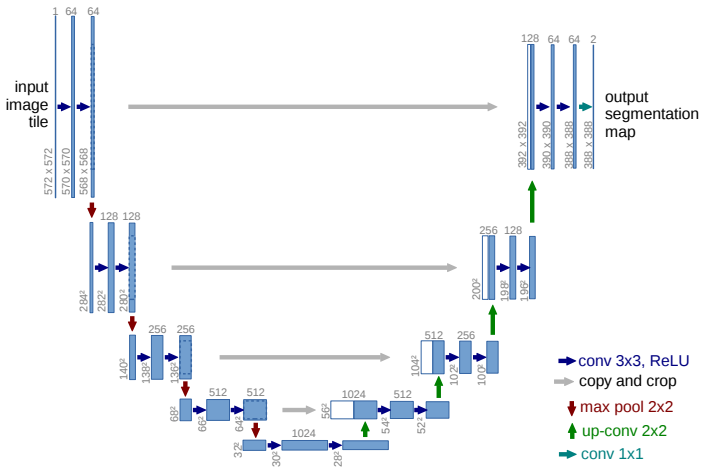

***Мы будем также использовать батчнорм-слои для лучшей устойчивости сети при обучнеии на различных лоссах. Также используем паддинг (1, 1), чтобы получить на выходе карту сегментации того же размера, что и входная картинка.***

In [ ]:
num_ch = 32 #Число каналов на выходе первого сверточного слоя 

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU()
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= num_ch*2, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU()
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),        
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size = 2, return_indices = False)
            
          
        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*16, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU()
        )        
                             
            
        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2)
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU()
        )       
        
        self.upsample1 =  nn.Upsample(scale_factor=2)
        
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU()
        )
        
        self.upsample2 =  nn.Upsample(scale_factor=2)
        
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2) 
        
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=1, kernel_size=1)
        )
        
        
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # bottleneck
        b = self.bottleneck_enc(e7)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim =1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim =1))        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim =1))           
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim =1))  
        return d3

Посмотрим на структуру получившейся сети:

In [ ]:
print(summary(UNet().to(DEVICE), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### 2.1 UNet c bce loss

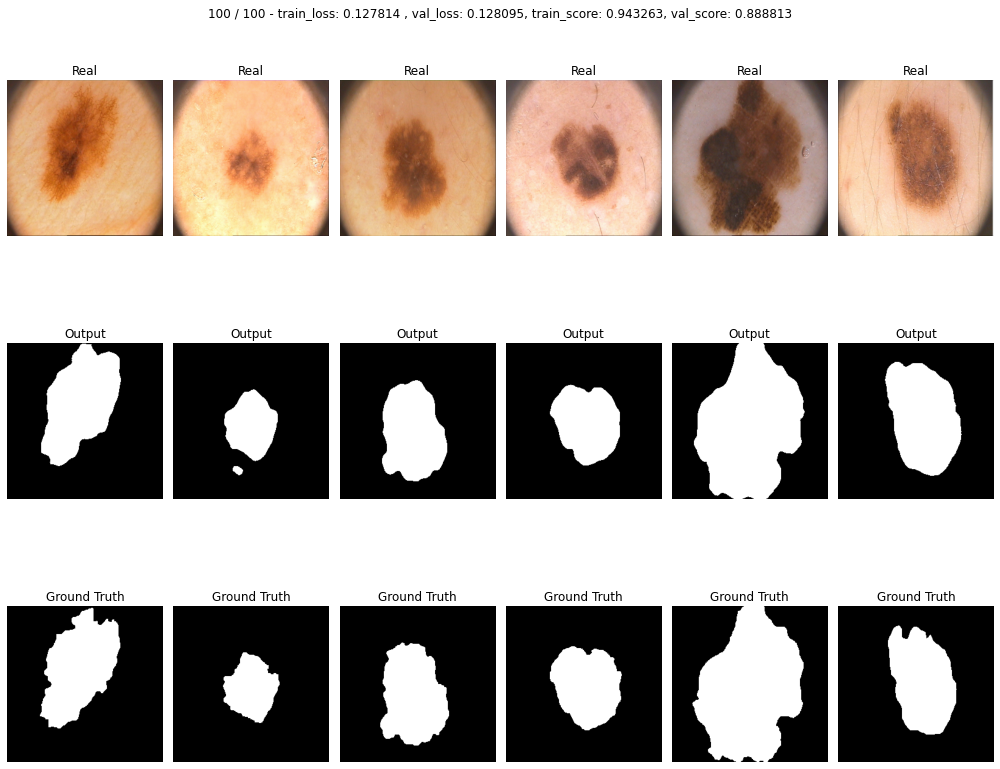

In [ ]:
torch.cuda.empty_cache()
unet_bce = UNet().to(DEVICE)
optimizer = torch.optim.AdamW(unet_bce.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_unet_bce = train(unet_bce, optimizer, bce_loss, max_epochs, data_tr, data_val)

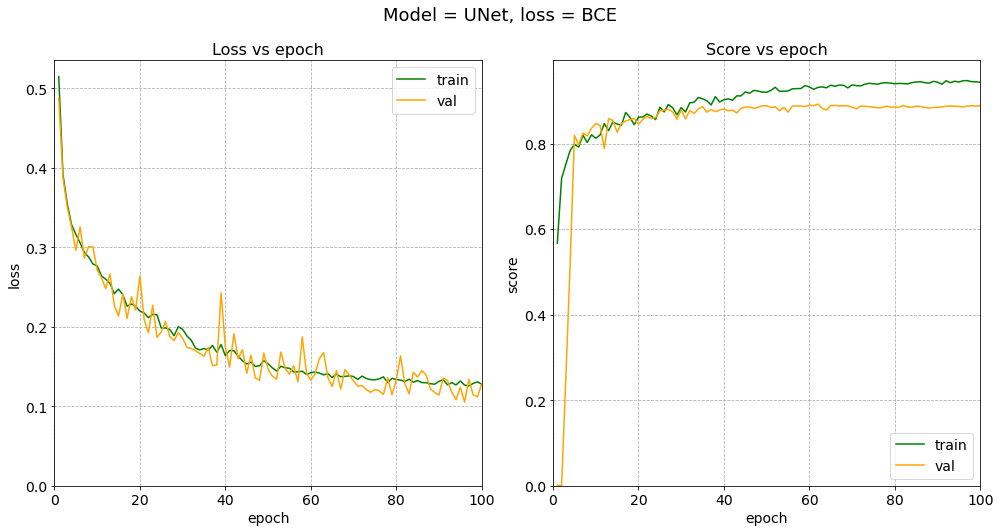

In [ ]:
make_graph(h_unet_bce, "UNet", "BCE")

In [ ]:
unet_bce_val_score, unet_bce_test_score = scores(unet_bce)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Score на валидации: 0.8888, score на тесте: 0.8704


### 2.2 UNet c dice loss

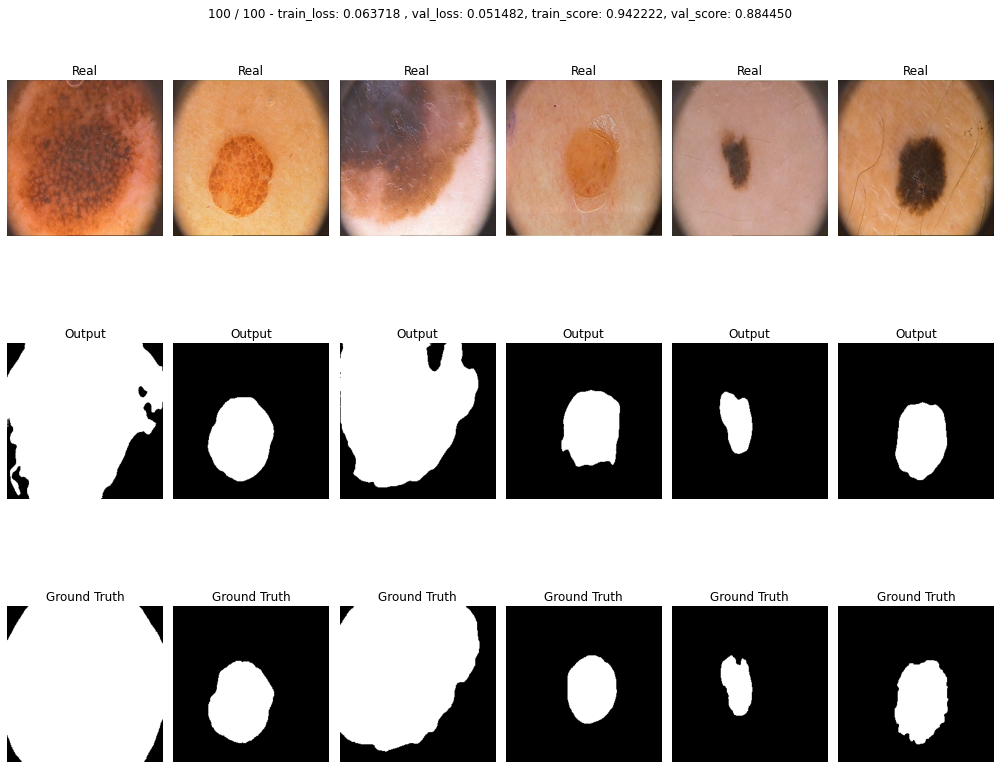

In [ ]:
torch.cuda.empty_cache()
unet_dice = UNet().to(DEVICE)
optimizer = torch.optim.AdamW(unet_dice.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_unet_dice = train(unet_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

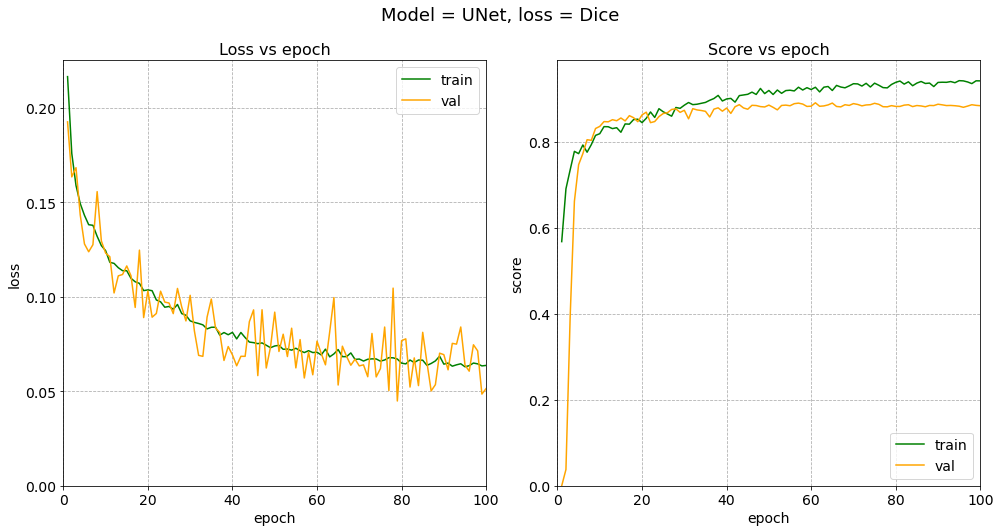

In [ ]:
make_graph(h_unet_dice, "UNet", "Dice")

In [ ]:
unet_dice_val_score, unet_dice_test_score = scores(unet_dice)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Score на валидации: 0.8844, score на тесте: 0.8598


### 2.3 UNet c Focal loss

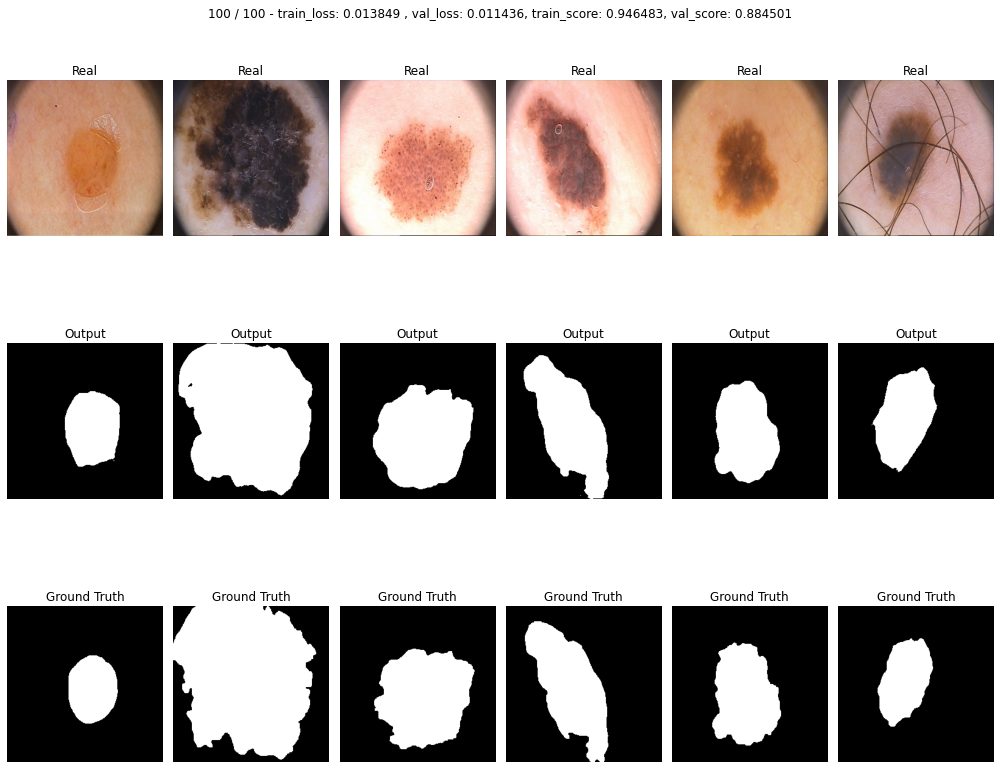

In [ ]:
torch.cuda.empty_cache()
unet_focal = UNet().to(DEVICE)
optimizer = torch.optim.AdamW(unet_focal.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_unet_focal = train(unet_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

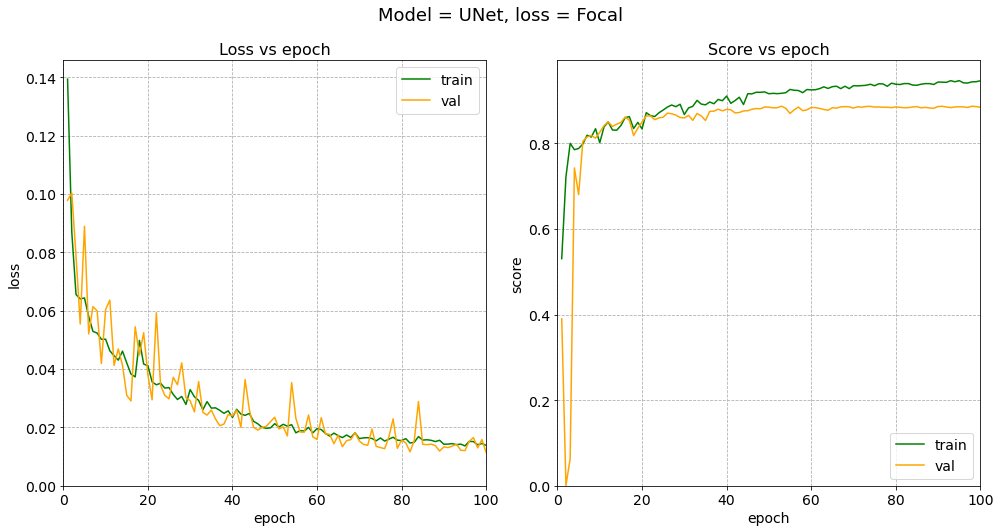

In [ ]:
make_graph(h_unet_focal, "UNet", "Focal")

In [ ]:
unet_focal_val_score, unet_focal_test_score = scores(unet_focal)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Score на валидации: 0.8845, score на тесте: 0.8664


### 2.4 UNet c  Structural Similarity Loss

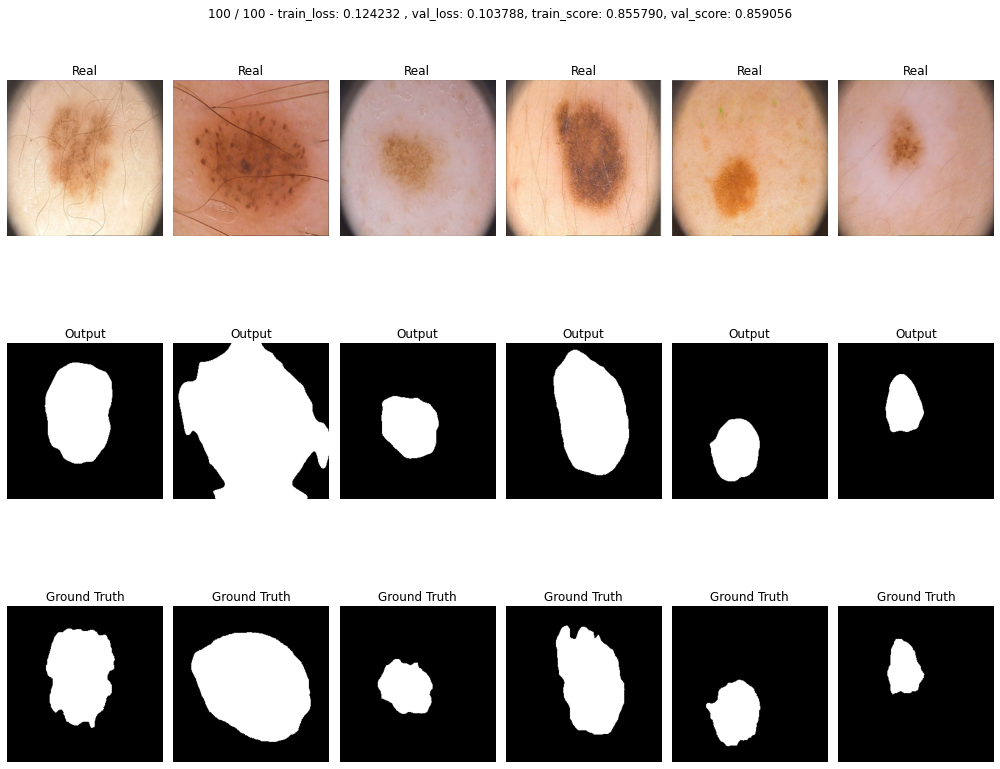

In [ ]:
torch.cuda.empty_cache()
unet_ssl = UNet().to(DEVICE)
optimizer = torch.optim.AdamW(unet_ssl.parameters(), lr = 1e-3, weight_decay = 0.01)
max_epochs = 100
h_unet_ssl = train(unet_ssl, optimizer, ssl_loss, max_epochs, data_tr, data_val)

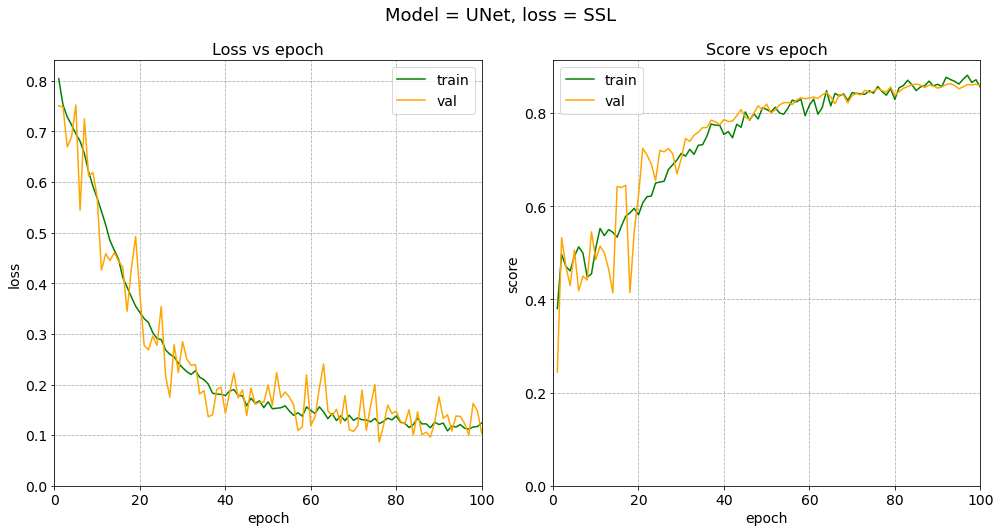

In [ ]:
make_graph(h_unet_ssl, "UNet", "SSL")

In [ ]:
unet_ssl_val_score, unet_ssl_test_score = scores(unet_ssl)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Score на валидации: 0.8591, score на тесте: 0.8379


### UNet2

Новая модель путем изменения типа пулинга:

Заменим max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
num_ch = 32
class UNet2(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU()
        )
        
        self.pool0 =  nn.Sequential(
        nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch),
        nn.ReLU()
        )
    
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = num_ch, out_channels = num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU()
        )
        
        
        self.pool1 =  nn.Sequential(
        nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch*2),
        nn.ReLU()
        )
        
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= num_ch*2, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU()
        )
        
        
        self.pool2 =  nn.Sequential(
        nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch*4),
        nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),        
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU()
        )
        
        
        self.pool3 =  nn.Sequential(
        nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch*8),
        nn.ReLU()
        )    
          
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*16, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU()
        )
        
       
            
        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=num_ch*8, out_channels=num_ch*8, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch*8),
        nn.ReLU()
        )
        
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*16, out_channels=num_ch*8, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU()
        )       
        
        
        self.upsample1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=num_ch*4, out_channels=num_ch*4, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch*4),
        nn.ReLU()
        )
        
        
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*8, out_channels=num_ch*4, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU()
        )
        
 
        self.upsample2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=num_ch*2, out_channels=num_ch*2, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch*2),
        nn.ReLU()
        )
        
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*4, out_channels=num_ch*2, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),           
            nn.BatchNorm2d(num_ch),
            nn.ReLU()
        )


        self.upsample3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=num_ch, out_channels=num_ch, kernel_size=2, stride = 2),
        nn.BatchNorm2d(num_ch),
        nn.ReLU()
        )
        
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=num_ch*2, out_channels=num_ch, kernel_size=3, padding = (1,1)),            
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=num_ch, kernel_size=3, padding = (1,1)),
            nn.BatchNorm2d(num_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_ch, out_channels=1, kernel_size=1)
        )
        
        
        
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # bottleneck
        b = self.bottleneck(e7)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim =1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim =1))        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim =1))           
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim =1)) # no activation  
        return d3    

***Посмотрим на струкутуру получившейся сети:***

In [ ]:
print(summary(UNet2().to(DEVICE), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 32, 128, 128]           4,128
       BatchNorm2d-8         [-1, 32, 128, 128]              64
              ReLU-9         [-1, 32, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          18,496
      BatchNorm2d-11         [-1, 64, 128, 128]             128
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,928
      BatchNorm2d-14         [-1, 64, 1

### 3.1 UNet2 c bce loss

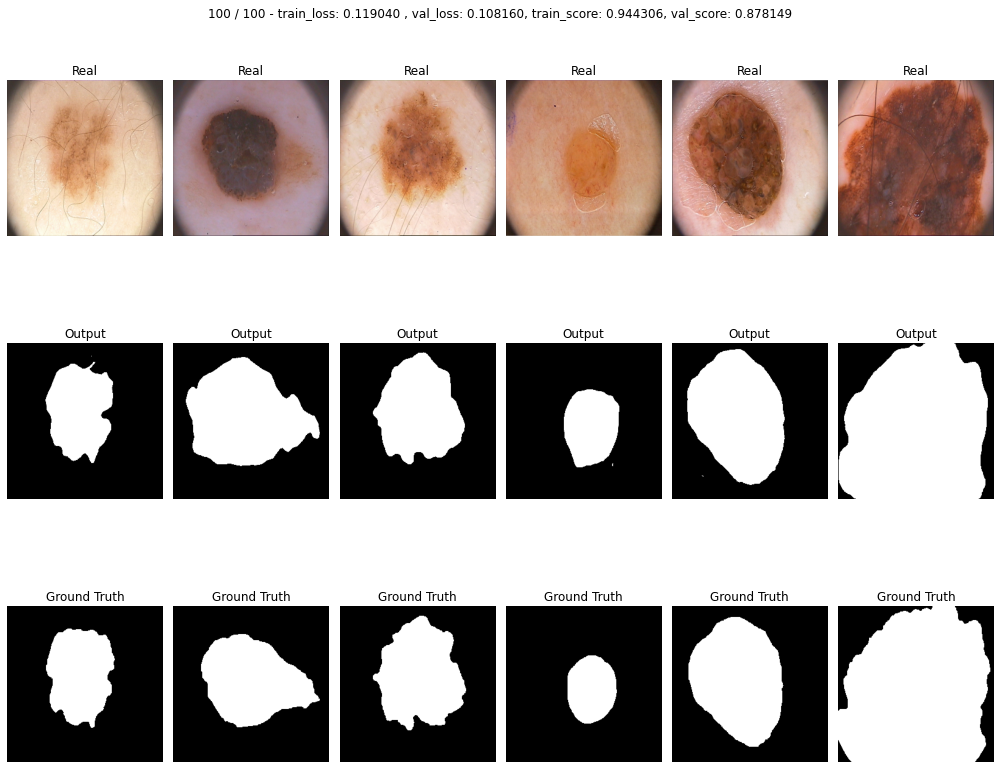

In [ ]:
torch.cuda.empty_cache()
unet2_bce = UNet2().to(DEVICE)
optimizer = torch.optim.AdamW(unet2_bce.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_unet2_bce = train(unet2_bce, optimizer, bce_loss, max_epochs, data_tr, data_val)

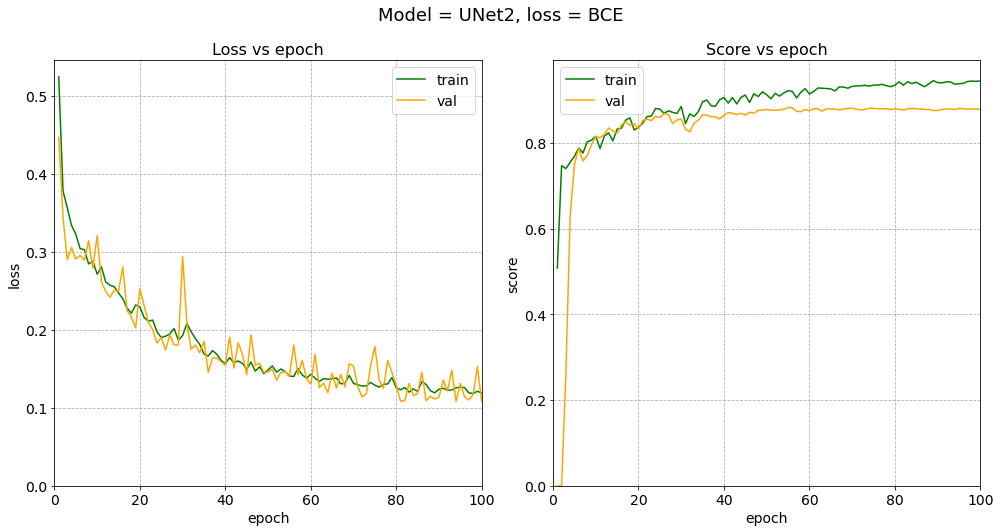

In [ ]:
make_graph(h_unet2_bce, "UNet2", "BCE")

In [ ]:
unet2_bce_val_score, unet2_bce_test_score = scores(unet2_bce)


Score на валидации: 0.8781, score на тесте: 0.8557


### 3.2 UNet2 c Dice loss

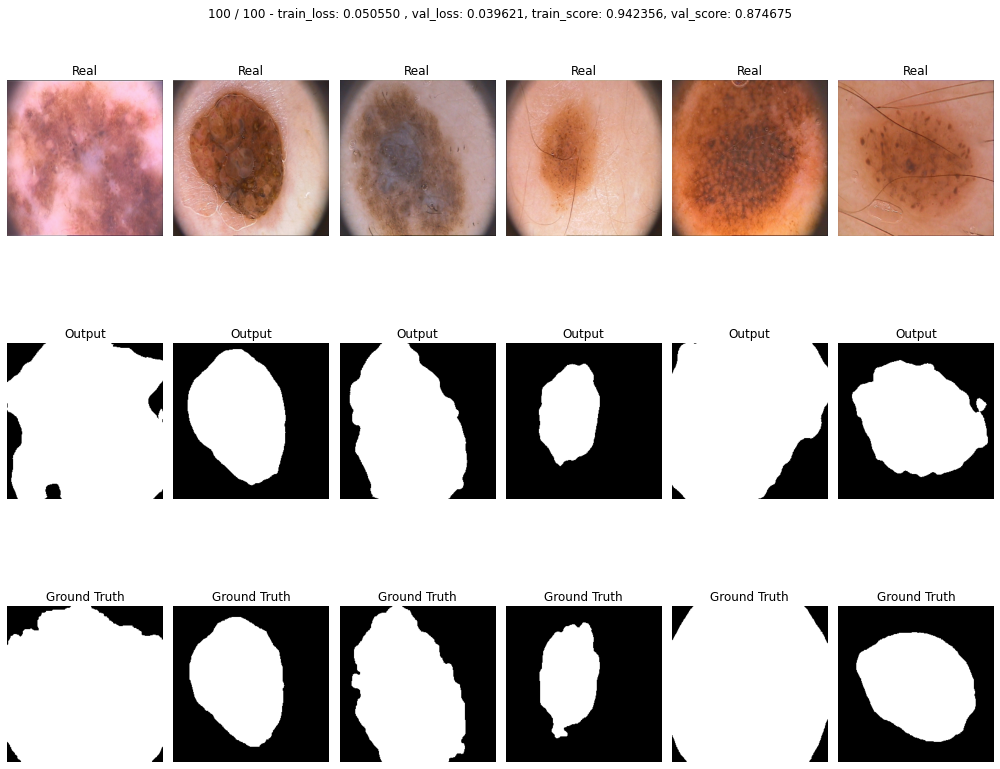

In [ ]:
torch.cuda.empty_cache()
unet2_dice = UNet2().to(DEVICE)
optimizer = torch.optim.AdamW(unet2_dice.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_unet2_dice = train(unet2_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

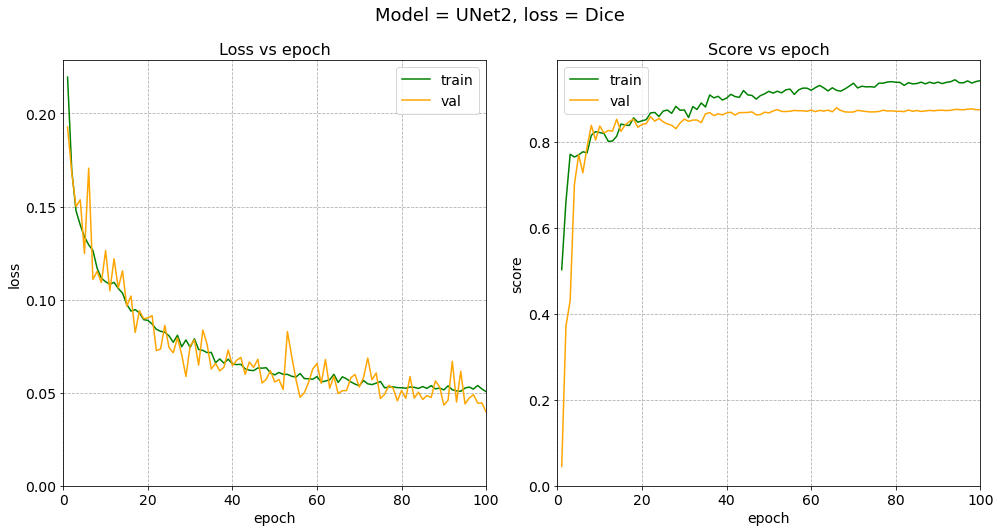

In [ ]:
make_graph(h_unet2_dice, "UNet2", "Dice")

In [ ]:
unet2_dice_val_score, unet2_dice_test_score = scores(unet2_dice)


Score на валидации: 0.8747, score на тесте: 0.8654


### 3.3 UNet2 c Focal loss

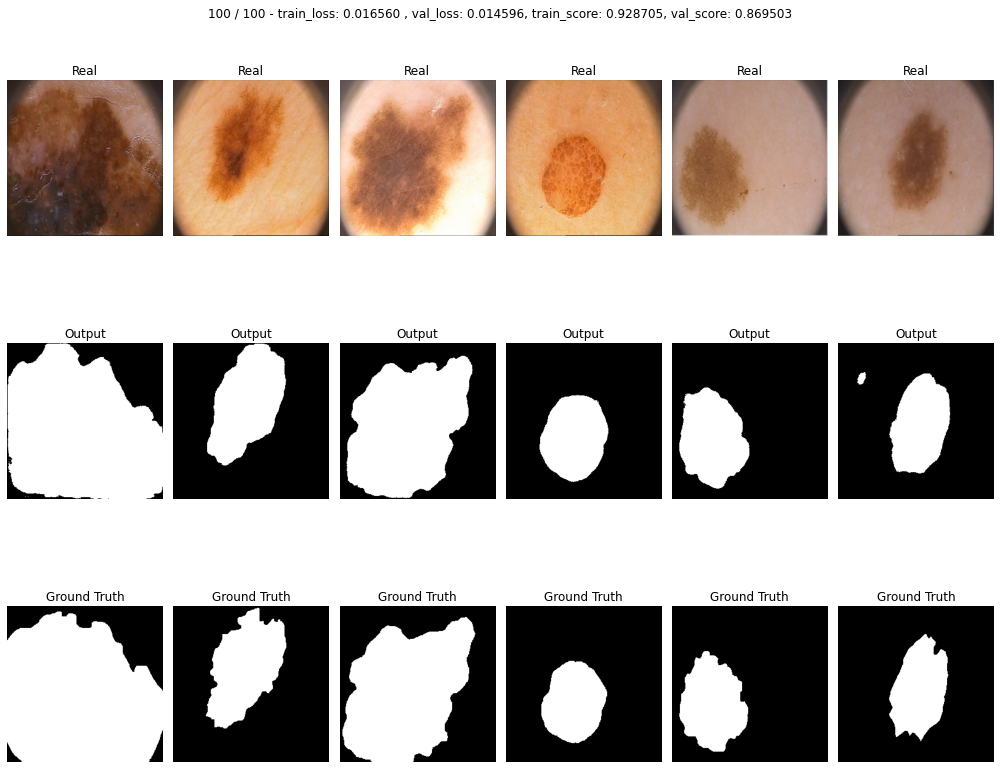

In [ ]:
torch.cuda.empty_cache()
unet2_focal = UNet2().to(DEVICE)
optimizer = torch.optim.AdamW(unet2_focal.parameters(), lr = 3e-4, weight_decay = 0.05)
max_epochs = 100
h_unet2_focal = train(unet2_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

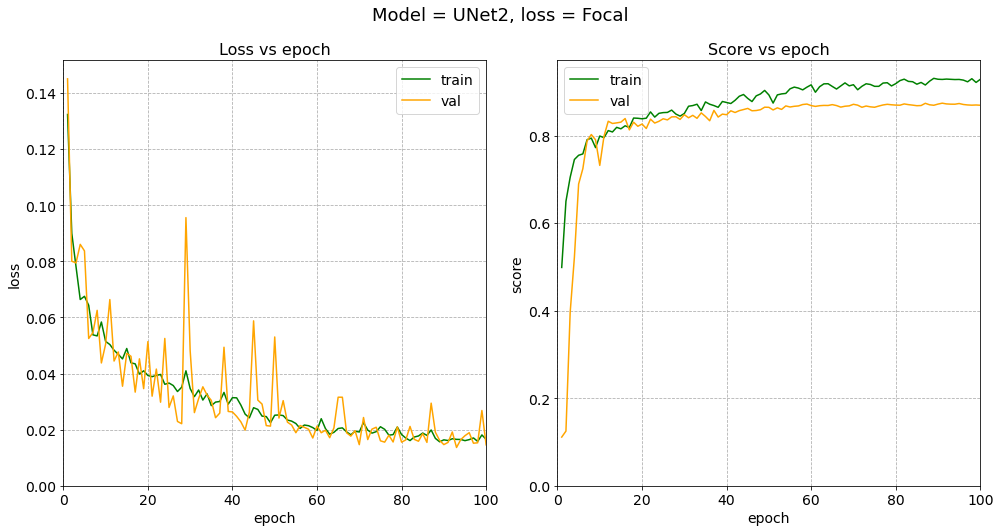

In [ ]:
make_graph(h_unet2_focal, "UNet2", "Focal")

In [ ]:
unet2_focal_val_score, unet2_focal_test_score = scores(unet2_focal)


Score на валидации: 0.8695, score на тесте: 0.8529


### 3.4 UNet2 c  Structural Similarity Loss

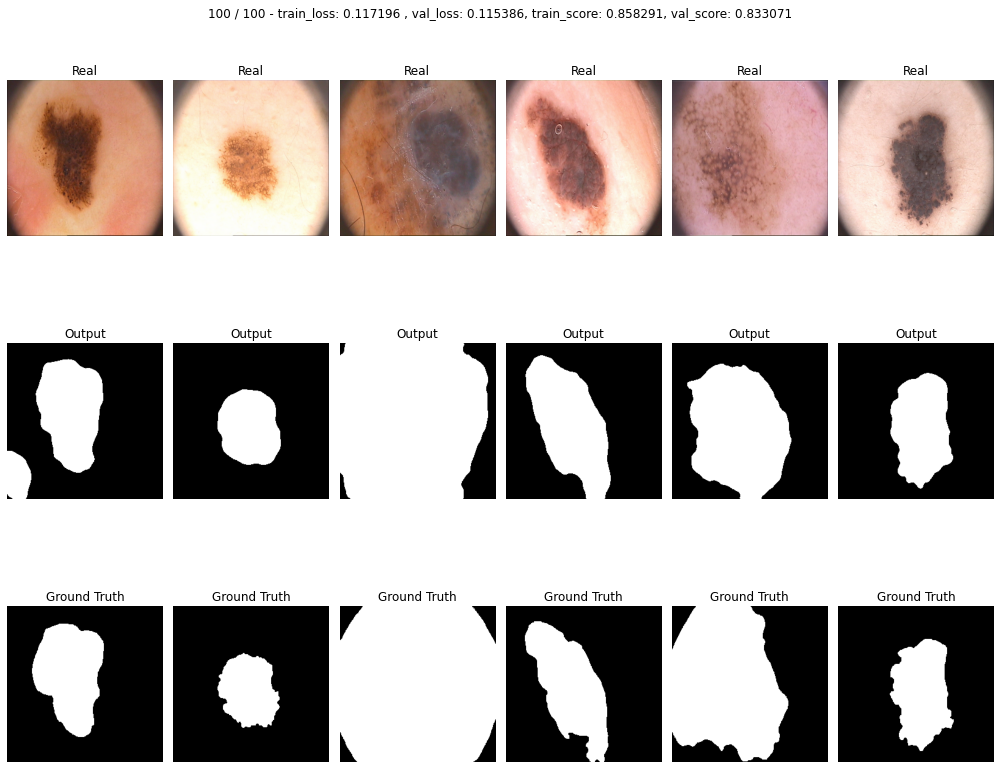

In [ ]:
torch.cuda.empty_cache()
unet2_ssl = UNet2().to(DEVICE)
optimizer = torch.optim.AdamW(unet2_ssl.parameters(), lr = 1e-3, weight_decay = 0.01)
max_epochs = 100
h_unet2_ssl = train(unet2_ssl, optimizer, ssl_loss, max_epochs, data_tr, data_val)

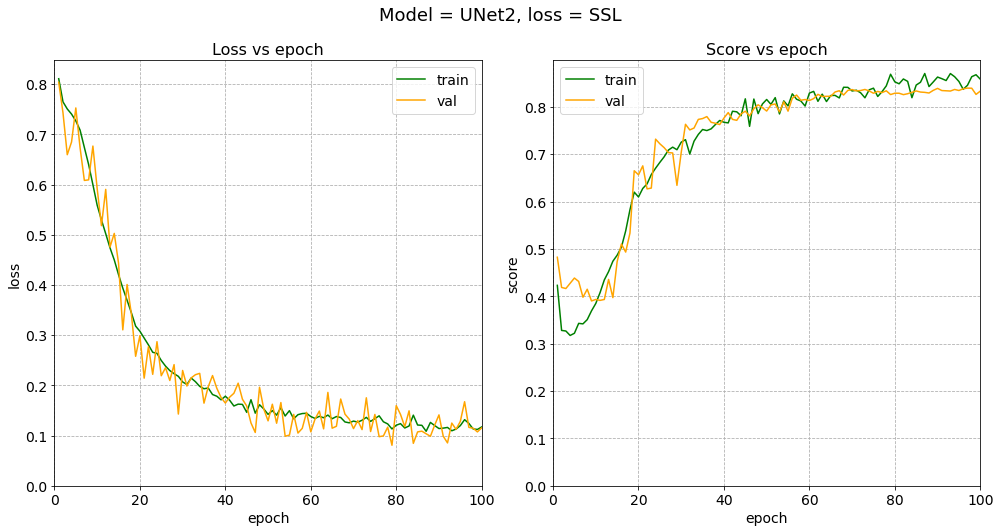

In [ ]:
make_graph(h_unet2_ssl, "UNet2", "SSL")

In [ ]:
unet2_ssl_val_score, unet2_ssl_test_score = scores(unet2_ssl)


Score на валидации: 0.8331, score на тесте: 0.8411


Сделайте вывод какая из моделей лучше

### 4.1 Анализ графиков лоссов по эпохам

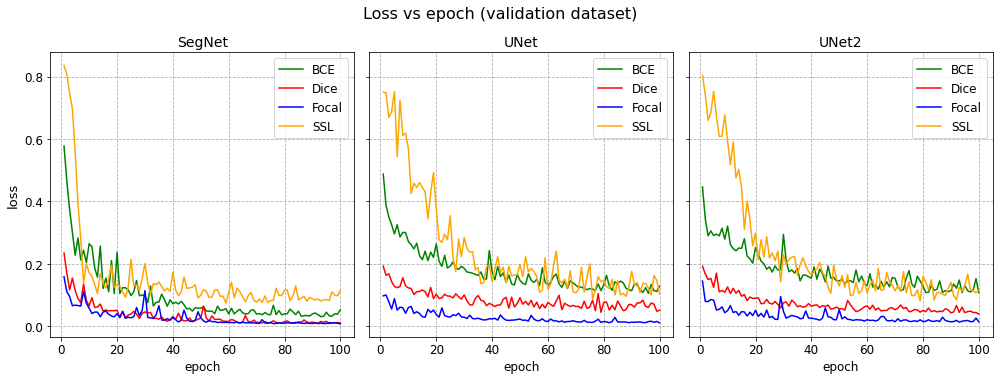

In [ ]:
x = np.arange(100)+1
fig, ax = plt.subplots(1, 3, figsize = (14, 5), sharey = True)

y1 = h_segnet_bce["val"]["loss"]
y2 = h_segnet_dice["val"]["loss"]
y3 = h_segnet_focal["val"]["loss"]
y4 = h_segnet_ssl["val"]["loss"]
ax[0].plot(x, y1, label = "BCE", color = "green")
ax[0].plot(x, y2, label = "Dice", color = "red")
ax[0].plot(x, y3, label = "Focal", color = "blue")
ax[0].plot(x, y4, label = "SSL", color = "orange")
ax[0].legend(fontsize = 12)
ax[0].grid(linestyle = "--")
ax[0].tick_params(labelsize = 12)
ax[0].set_ylabel("loss", fontsize = 13)
ax[0].set_title("SegNet", fontsize = 14)
ax[0].set_xlabel("epoch", fontsize = 12)

y1 = h_unet_bce["val"]["loss"]
y2 = h_unet_dice["val"]["loss"]
y3 = h_unet_focal["val"]["loss"]
y4 = h_unet_ssl["val"]["loss"]
ax[1].plot(x, y1, label = "BCE", color = "green")
ax[1].plot(x, y2, label = "Dice", color = "red")
ax[1].plot(x, y3, label = "Focal", color = "blue")
ax[1].plot(x, y4, label = "SSL", color = "orange")
ax[1].legend(fontsize = 12)
ax[1].grid(linestyle = "--")
ax[1].tick_params(labelsize = 12)
ax[1].set_title("UNet", fontsize = 14)
ax[1].set_xlabel("epoch", fontsize = 12)

y1 = h_unet2_bce["val"]["loss"]
y2 = h_unet2_dice["val"]["loss"]
y3 = h_unet2_focal["val"]["loss"]
y4 = h_unet2_ssl["val"]["loss"]
ax[2].plot(x, y1, label = "BCE", color = "green")
ax[2].plot(x, y2, label = "Dice", color = "red")
ax[2].plot(x, y3, label = "Focal", color = "blue")
ax[2].plot(x, y4, label = "SSL", color = "orange")
ax[2].legend(fontsize = 12)
ax[2].grid(linestyle = "--")
ax[2].tick_params(labelsize = 12)
ax[2].set_title("UNet2", fontsize = 14)
ax[2].set_xlabel("epoch", fontsize = 12)
plt.suptitle(f"Loss vs epoch (validation dataset)", fontsize = 16, y=1.05)
plt.tight_layout()

Лоссы SSL и BCE имеют бОльшие стартовые значения, а также бОльшие значения после 100 эпох, чем Dice и Focal. По асболютным значениям лоссы больше всего у модели UNet2, меньше всего - у модели SegNet. Наименьшие значения во всех моделях показывает лосс Focal, наибольшие - SSL. Однако, наименьшее знечение лосса еще не говорит о наибольшем значении скора, что будет показано далее.

### 4.2 Анализ графиков скора по эпохам в зависимости от модели

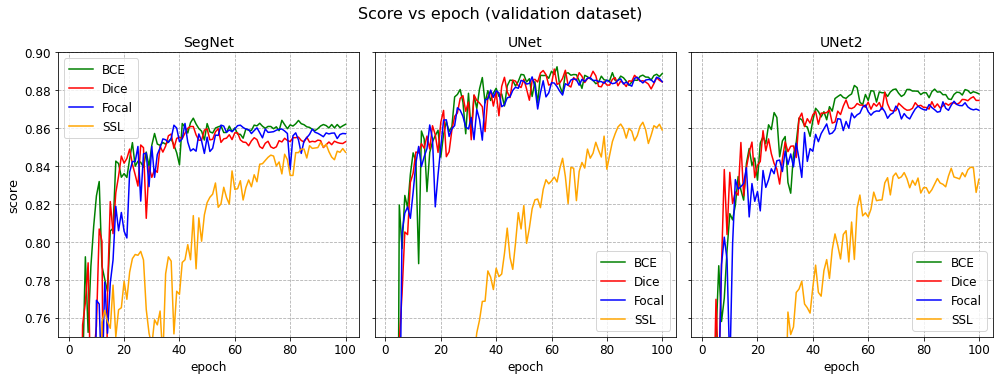

In [ ]:
x = np.arange(100)+1
fig, ax = plt.subplots(1, 3, figsize = (14, 5), sharey = True)

y1 = h_segnet_bce["val"]["score"]
y2 = h_segnet_dice["val"]["score"]
y3 = h_segnet_focal["val"]["score"]
y4 = h_segnet_ssl["val"]["score"]
ax[0].plot(x, y1, label = "BCE", color = "green")
ax[0].plot(x, y2, label = "Dice", color = "red")
ax[0].plot(x, y3, label = "Focal", color = "blue")
ax[0].plot(x, y4, label = "SSL", color = "orange")
ax[0].legend(fontsize = 12)
ax[0].grid(linestyle = "--")
ax[0].tick_params(labelsize = 12)
ax[0].set_ylabel("score", fontsize = 13)
ax[0].set_title("SegNet", fontsize = 14)
ax[0].set_xlabel("epoch", fontsize = 12)
ax[0].set_ylim(0.75, 0.9)

y1 = h_unet_bce["val"]["score"]
y2 = h_unet_dice["val"]["score"]
y3 = h_unet_focal["val"]["score"]
y4 = h_unet_ssl["val"]["score"]
ax[1].plot(x, y1, label = "BCE", color = "green")
ax[1].plot(x, y2, label = "Dice", color = "red")
ax[1].plot(x, y3, label = "Focal", color = "blue")
ax[1].plot(x, y4, label = "SSL", color = "orange")
ax[1].legend(fontsize = 12)
ax[1].grid(linestyle = "--")
ax[1].tick_params(labelsize = 12)
ax[1].set_title("UNet", fontsize = 14)
ax[1].set_xlabel("epoch", fontsize = 12)
ax[1].set_ylim(0.75, 0.9)

y1 = h_unet2_bce["val"]["score"]
y2 = h_unet2_dice["val"]["score"]
y3 = h_unet2_focal["val"]["score"]
y4 = h_unet2_ssl["val"]["score"]
ax[2].plot(x, y1, label = "BCE", color = "green")
ax[2].plot(x, y2, label = "Dice", color = "red")
ax[2].plot(x, y3, label = "Focal", color = "blue")
ax[2].plot(x, y4, label = "SSL", color = "orange")
ax[2].legend(fontsize = 12)
ax[2].grid(linestyle = "--")
ax[2].tick_params(labelsize = 12)
ax[2].set_title("UNet2", fontsize = 14)
ax[2].set_xlabel("epoch", fontsize = 12)
ax[2].set_ylim(0.75, 0.9)
plt.suptitle(f"Score vs epoch (validation dataset)", fontsize = 16, y=1.05)
plt.tight_layout()
plt.show()

Из графиков мы видим, что наилучшие результаты в скоре при любом лоссе дает модель UNet, далее идет UNet2 (за исключением скора при лоссе SSL, который оказался выше у SegNet), хуже всех себя показала SegNet. Skip-connections моделей UNet действительно приводят к улучшению качества. Лучшим лоссом на валидационном датасете оказывается BCE, однако Dice и Focal дают почти такой же скор, отрыв совсем не велик. Ощутимо в рамках данной задачи проигрывает SSL, особенно на сетях типа UNet. На сетях типа UNet Dice показал себя лучше, чем Focal, на Segnet - Focal лучше Dice.

### 4.3 Анализ графиков скора по эпохам в зависимости от лосса

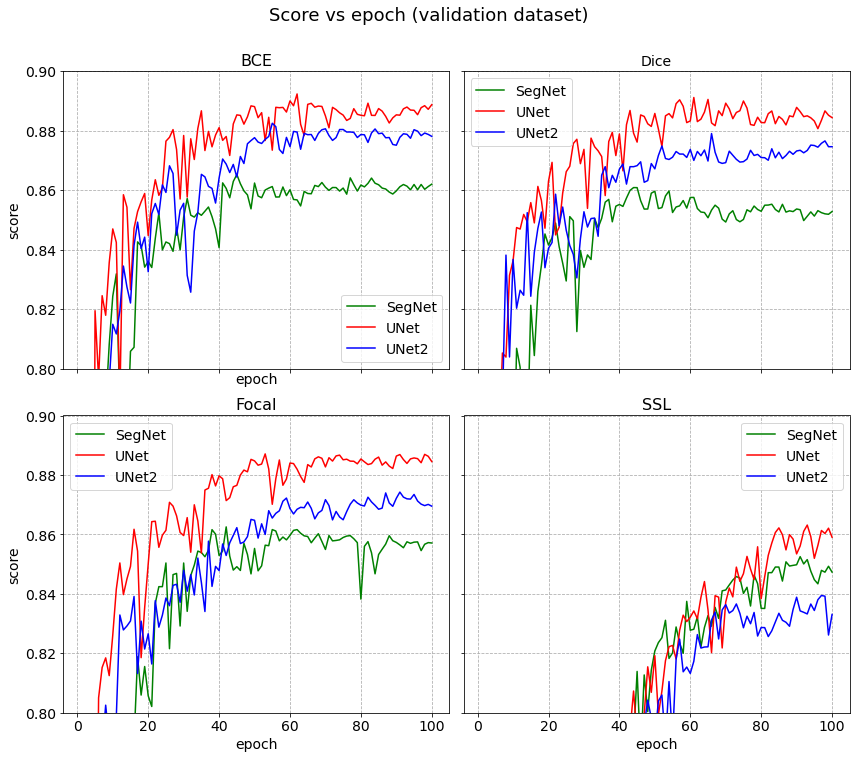

In [ ]:
x = np.arange(100)+1
fig, ax = plt.subplots(2, 2, figsize = (12, 10), sharey = True, sharex = True)
y1 = h_segnet_bce["val"]["score"]
y2 = h_unet_bce["val"]["score"]
y3 = h_unet2_bce["val"]["score"]
ax[0, 0].plot(x, y1, label = "SegNet", color = "green")
ax[0, 0].plot(x, y2, label = "UNet", color = "red")
ax[0, 0].plot(x, y3, label = "UNet2", color = "blue")
ax[0, 0].legend(fontsize = 14)
ax[0, 0].grid(linestyle = "--")
ax[0, 0].tick_params(labelsize = 14)
ax[0, 0].set_ylabel("score", fontsize = 14)
ax[0, 0].set_title("BCE", fontsize = 16)
ax[0, 0].set_xlabel("epoch", fontsize = 14)
ax[0, 0].set_ylim(0.8, 0.9)

y1 = h_segnet_dice["val"]["score"]
y2 = h_unet_dice["val"]["score"]
y3 = h_unet2_dice["val"]["score"]
ax[0, 1].plot(x, y1, label = "SegNet", color = "green")
ax[0, 1].plot(x, y2, label = "UNet", color = "red")
ax[0, 1].plot(x, y3, label = "UNet2", color = "blue")
ax[0, 1].legend(fontsize = 14)
ax[0, 1].grid(linestyle = "--")
ax[0, 1].tick_params(labelsize = 16)
ax[0, 1].set_title("Dice", fontsize = 14)
ax[0, 1].set_ylim(0.8, 0.9)


y1 = h_segnet_focal["val"]["score"]
y2 = h_unet_focal["val"]["score"]
y3 = h_unet2_focal["val"]["score"]
ax[1, 0].plot(x, y1, label = "SegNet", color = "green")
ax[1, 0].plot(x, y2, label = "UNet", color = "red")
ax[1, 0].plot(x, y3, label = "UNet2", color = "blue")
ax[1, 0].legend(fontsize = 14)
ax[1, 0].grid(linestyle = "--")
ax[1, 0].tick_params(labelsize = 14)
ax[1, 0].set_ylabel("score", fontsize = 14)
ax[1, 0].set_title("Focal", fontsize = 16)
ax[1, 0].set_xlabel("epoch", fontsize = 14)
ax[1, 0].set_ylim(0.8, 0.9)


y1 = h_segnet_ssl["val"]["score"]
y2 = h_unet_ssl["val"]["score"]
y3 = h_unet2_ssl["val"]["score"]
ax[1, 1].plot(x, y1, label = "SegNet", color = "green")
ax[1, 1].plot(x, y2, label = "UNet", color = "red")
ax[1, 1].plot(x, y3, label = "UNet2", color = "blue")
ax[1, 1].legend(fontsize = 14)
ax[1, 1].grid(linestyle = "--")
ax[1, 1].tick_params(labelsize = 14)
ax[1, 1].set_title("SSL", fontsize = 16)
ax[1, 1].set_xlabel("epoch", fontsize = 14)
ax[1, 1].set_ylim(0.8, 0.9)


plt.suptitle(f"Score vs epoch (validation dataset)", fontsize = 18, y=1.05)
plt.tight_layout()
plt.show()

Здесь мы опять видим, что UNet превосходит остальные модели на всех лоссах, далее идет UNet2 (за исключением лосса SSL, где оказывается лучше Segnet), SegNet замыкает список.

### 4.4 Анализ скора на тестовом датасете

In [ ]:
y = [segnet_bce_test_score, segnet_dice_test_score, segnet_focal_test_score, segnet_ssl_test_score,
     unet_bce_test_score, unet_dice_test_score, unet_focal_test_score, unet_ssl_test_score,
     unet2_bce_test_score, unet2_dice_test_score, unet2_focal_test_score, unet2_ssl_test_score]

x = ['segnet_bce', 'segnet_dice', 'segnet_focal', 'segnet_ssl',
     'unet_bce', 'unet_dice', 'unet_focal', 'unet_ssl',
     'unet2_bce', 'unet2_dice', 'unet2_focal', 'unet2_ssl']

from matplotlib import cm
colors = cm.get_cmap("viridis", 12).colors

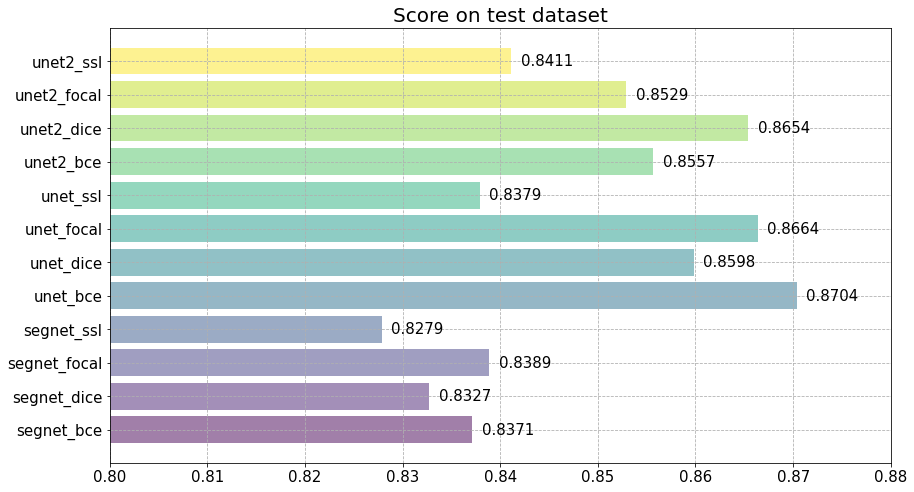

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8))
ax.barh(x, y, color = colors, alpha = 0.5)
ax.set_xlim(0.8, 0.88)
ax.tick_params(labelsize = 15)
for i in range(12):
    ax.text(y[i]+0.001, i - 0.15, f"{y[i]:.4f}", fontsize = 15)
    ax.grid(linestyle="--")
ax.set_title("Score on test dataset", fontsize = 20)
plt.show()

На тестовом датасете модеи UNet опережают Segnet уже при каждом виде лосса. На SegNet лучшим лоссом оказался focal, на UNet - BCE, на UNet2 -Dice. Кроме того, на тестовом датасете UNet2 опередила UNet при лоссах SSL и Dice (на валидационном она была хуже UNet при всех видах лоссов).

### 4.5 Заключение и общие выводы

Из приведенного выше можно сделать вывод, что лучшей моделью для данной задачи является UNet. Однако, отставание UNet2 совсем небольшое, а на тестовом датасете при двух лоссах она даже смогла обогнать UNet. Модель SegNet показывает стабильно худшее качество, чем модели UNet (skip-connections работают и работают хорошо). Лоссы BCE, Dice и Focal практически эквивалентны с точки зрения получения итогового скора. Какой из них покажет лучший результат в конкретной модели на конкретном датасете (валидационном или тестовом) зависит в том числе и от первоначального разделения датасета на тренировочный, валидационный и тестовый, поскольку исходный общий датасет достаточно "зашумлен", и в нем попадаются такие картинки, как первая картинка в пункте 2.2 настоящей работы.

Здесь мы видим некорректный Ground Truth, и таких картинок в нашем датасете далеко не одна. Поэтому, от того, насколько много таких картинок попадет в конкретный датасет, будет зависеть и скор на этом датасете. Что можно сказать однозначно, так это то, что лосс SSL для данной задачи проявил себя хуже остальных с точки зрения итогового скора. Однако, как видно из пп. 1.6, 2.4, 3.4 с этим лоссом переобучение сетей отсутствует, и скор на трейне практически одинаков со скором на валидации. В этом SSL лучше, чем Dice, BCE или Focal. Также на сетях типа UNet разрыв между скором на трейне и валидации меньше, чем для SegNet, как видно из графиков пп.1, 2, 3. Сети UNet не только показывают лучший скор, чем SegNet, но и менее склонны к переобучению.